<a href="https://colab.research.google.com/github/bickkysahani/timeseries-forecasting/blob/main/timeseries_forecasting_6_weather_prediction_random_forest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [175]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Weather_data.csv', parse_dates =['datetime (UTC)'])


In [176]:
df.head()

,datetime (UTC),"coordinates (lat,lon)",model (name),model elevation (surface),utc_offset (hrs),temperature (degC),dewpoint_temperature (degC),wind_speed (m/s),mean_sea_level_pressure (Pa),relative_humidity ((0-1)),surface_solar_radiation (W/m^2),surface_thermal_radiation (W/m^2),total_cloud_cover (0-1)
0,2010-01-01 00:00:00,"(-37.91, 145.13)",era5,69.59,10.0,18.26,16.39,2.60,101046.38,0.89,287.01,408.35,1.0
1,2010-01-01 01:00:00,"(-37.91, 145.13)",era5,69.59,10.0,18.67,16.29,2.91,101037.96,0.86,360.79,411.02,1.0
2,2010-01-01 02:00:00,"(-37.91, 145.13)",era5,69.59,10.0,18.16,15.89,3.26,101017.26,0.87,291.54,410.67,1.0
3,2010-01-01 03:00:00,"(-37.91, 145.13)",era5,69.59,10.0,18.46,15.33,3.17,101022.56,0.82,357.11,410.95,1.0
4,2010-01-01 04:00:00,"(-37.91, 145.13)",era5,69.59,10.0,18.53,15.11,2.95,100940.03,0.80,459.91,410.00,0.9


In [177]:
#Lets rename some columns
df = df.rename(columns={'datetime (UTC)':'Date Time',
                                 'coordinates (lat,lon)':'coordinates',
                                  'model (name)':'model',
                                  'model elevation (surface)':'model elevation'
                                  ,'utc_offset (hrs)':'utc',
                                   'temperature (degC)':'Temperature',
                                   'dewpoint_temperature (degC)':'Temperature(dw)',
                                   'wind_speed (m/s)':'Wind Speed',
                                   'mean_sea_level_pressure (Pa)':'Pressure',
                                   'relative_humidity ((0-1))':'Relative Humidity',
                                  'surface_solar_radiation (W/m^2)':'Solar Radiation',
                                  'surface_thermal_radiation (W/m^2)':'Thermal Radiation',
                                  'total_cloud_cover (0-1)':'Total Cloud Cover'
                                  })
#drop some unnecessary columns
df.drop(columns=['coordinates','model','model elevation','utc'], axis=1, inplace=True)
df.index = df['Date Time']
df['Pressure'] = df['Pressure'].apply(lambda x: x*0.01)



```
# This is formatted as code
```



In [178]:
df.head()

,Date Time,Temperature,Temperature(dw),Wind Speed,Pressure,Relative Humidity,Solar Radiation,Thermal Radiation,Total Cloud Cover
Date Time,,,,,,,,,
2010-01-01 00:00:00,2010-01-01 00:00:00,18.26,16.39,2.60,1010.4638,0.89,287.01,408.35,1.0
2010-01-01 01:00:00,2010-01-01 01:00:00,18.67,16.29,2.91,1010.3796,0.86,360.79,411.02,1.0
2010-01-01 02:00:00,2010-01-01 02:00:00,18.16,15.89,3.26,1010.1726,0.87,291.54,410.67,1.0
2010-01-01 03:00:00,2010-01-01 03:00:00,18.46,15.33,3.17,1010.2256,0.82,357.11,410.95,1.0
2010-01-01 04:00:00,2010-01-01 04:00:00,18.53,15.11,2.95,1009.4003,0.80,459.91,410.00,0.9


In [179]:
features_considered = ['Temperature']
df = df[features_considered]
# df.index = df['Date Time']
df.head()
df = df[['Temperature']]
df

,Temperature
Date Time,
2010-01-01 00:00:00,18.26
2010-01-01 01:00:00,18.67
2010-01-01 02:00:00,18.16
2010-01-01 03:00:00,18.46
2010-01-01 04:00:00,18.53
...,...
2021-05-31 20:00:00,8.31
2021-05-31 21:00:00,8.15
2021-05-31 22:00:00,8.72


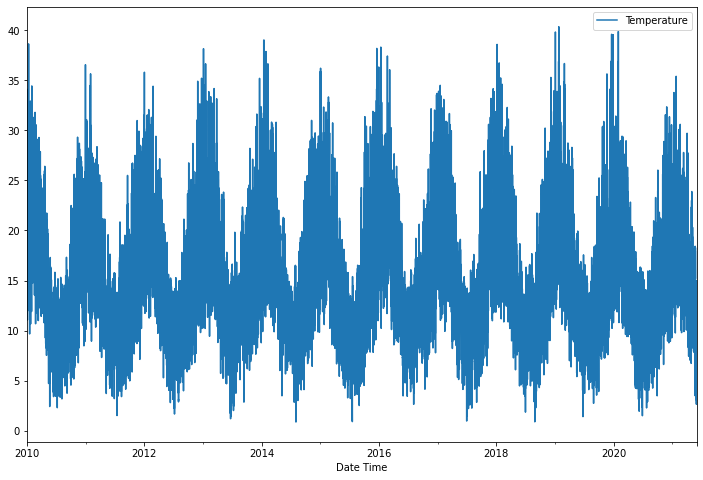

In [180]:
df.columns = ['Temperature']
df.plot(figsize=(12,8))

In [182]:
df['Temperature_Past1Hour'] = df['Temperature'].shift(+1)
df['Temperature_Past2Hour'] = df['Temperature'].shift(+2)
df['Temperature_Past3Hour'] = df['Temperature'].shift(+3)

df.head()


,Temperature,Temperature_Past1Hour,Temperature_Past2Hour,Temperature_Past3Hour
Date Time,,,,
2010-01-01 00:00:00,18.26,NaN,NaN,NaN
2010-01-01 01:00:00,18.67,18.26,NaN,NaN
2010-01-01 02:00:00,18.16,18.67,18.26,NaN
2010-01-01 03:00:00,18.46,18.16,18.67,18.26
2010-01-01 04:00:00,18.53,18.46,18.16,18.67


In [184]:
df= df.dropna()
df

,Temperature,Temperature_Past1Hour,Temperature_Past2Hour,Temperature_Past3Hour
Date Time,,,,
2010-01-01 03:00:00,18.46,18.16,18.67,18.26
2010-01-01 04:00:00,18.53,18.46,18.16,18.67
2010-01-01 05:00:00,18.92,18.53,18.46,18.16
2010-01-01 06:00:00,19.22,18.92,18.53,18.46
2010-01-01 07:00:00,19.41,19.22,18.92,18.53
...,...,...,...,...
2021-05-31 20:00:00,8.31,8.33,8.65,9.01
2021-05-31 21:00:00,8.15,8.31,8.33,8.65
2021-05-31 22:00:00,8.72,8.15,8.31,8.33


In [186]:
import numpy as np
x1,x2,x3,y = df['Temperature_Past1Hour'],df['Temperature_Past2Hour'],df['Temperature_Past3Hour'],df['Temperature']
x1,x2,x3,y = np.array(x1),np.array(x2),np.array(x3),np.array(y)
x1,x2,x3,y = x1.reshape(-1,1),x2.reshape(-1,1),x3.reshape(-1,1),y.reshape(-1,1)
final_x = np.concatenate((x1,x2,x3),axis=1)
print(final_x)

[[18.16 18.67 18.26]
 [18.46 18.16 18.67]
 [18.53 18.46 18.16]
 ...
 [ 8.15  8.31  8.33]
 [ 8.72  8.15  8.31]
 [ 9.83  8.72  8.15]]


In [195]:
#X_train,X_test,y_train,y_test = final_x[:71540],final_x[71540:],y[:71540],y[71540:]
X_train,X_test,y_train,y_test = final_x[:-30],final_x[-30:],y[:-30],y[-30:]

In [196]:
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((100024, 3), (30, 3), (100024, 1), (30, 1))

In [197]:
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor(n_estimators=100,max_features=3,random_state=1)

In [198]:
model.fit(X_train,y_train)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """Entry point for launching an IPython kernel.


RandomForestRegressor(max_features=3, random_state=1)

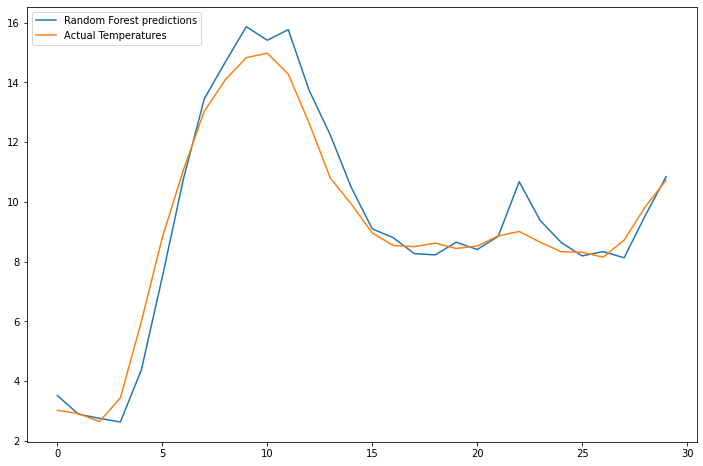

In [199]:
pred = model.predict(X_test)
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (12,8)
plt.plot(pred,label="Random Forest predictions")
plt.plot(y_test,label="Actual Temperatures")
plt.legend(loc="upper left")
plt.show()

In [200]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse = sqrt(mean_squared_error(pred,y_test))


In [201]:
print("Mean Squared Error for Random Forest Model is:",rmse)

Mean Squared Error for Random Forest Model is: 0.7577093884421238


In [202]:
#worked 3 hours (completed)